# 1. Objetivo

La idea del proyecto es realizar una clasificación de imágenes en tres clases -> Frutas, Vegetales y Paquetes.

## Dataset de referencia
_*A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels*_,<br>
Klasson, Marcus and Zhang, Cheng and Kjellstr, <br>
IEEE Winter Conference on Applications of Computer Vision (WACV), 2019.


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K
from tensorflow.keras import optimizers

In [2]:
def plot_accuracy(x, acc, val_acc, loss, val_loss):
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.ylim(bottom=0, top=1.2)

    plt.figure()

    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.ylim(bottom=0, top=1)

    plt.show()

In [3]:
# !git clone https://github.com/marcusklasson/GroceryStoreDataset

In [4]:
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2640 files belonging to 3 classes.
Found 296 files belonging to 3 classes.


Inspeccionamos el dataset para ver algún subset de imágenes

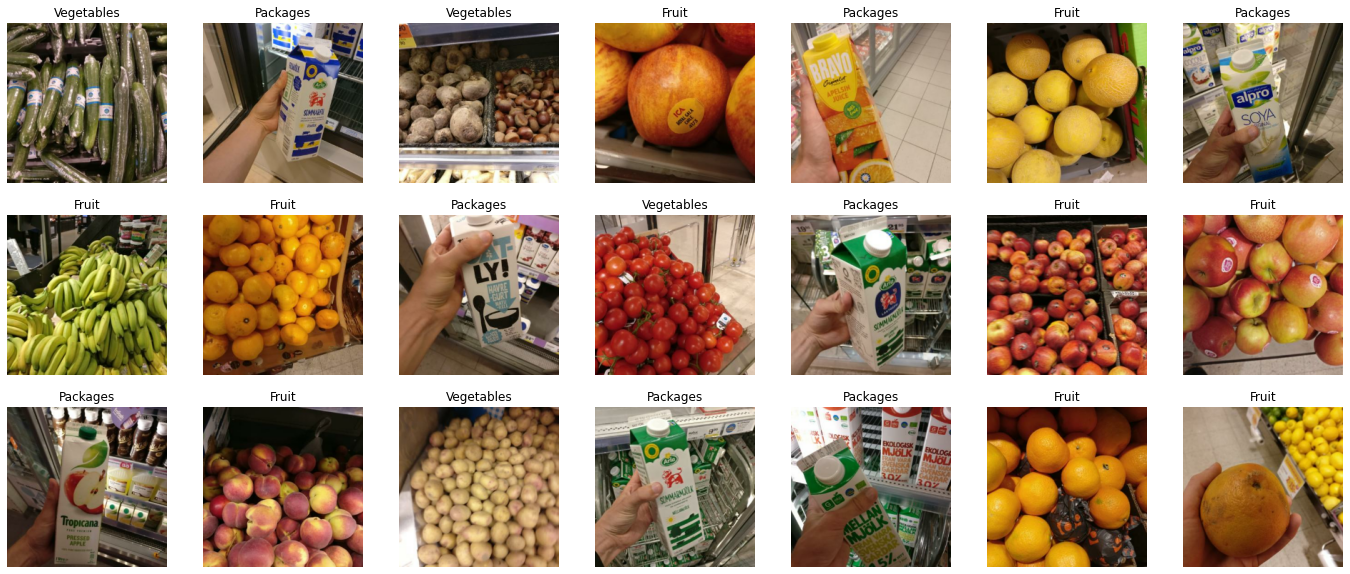

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(24, 10))
for images, labels in train_dataset.take(1):
    for i in range(21):
        ax = plt.subplot(3, 7, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Preprocesamiento inicial de datos
Se crean algunos preprocesamientos sin ningun variación ni aumento de los datos.

In [7]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [8]:
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


# Modelos
Se implementan dos modelos:
- Una red convolucional de base (modelo 1)
- Un red convolucional que incluye capas de MaxPooling, Flatten y Dense (modelo 2)

Sobre este segundo modelo se aplica aumento de datos y regularización (dropout) para evitar potencial overfitting.

In [9]:
CLASSES = len(class_names)
EPOCHS = 50
LEARNING_RATE = 1e-4

## Modelo 1

In [10]:
from keras import layers
from keras import models

model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(96, activation='relu'))
model_1.add(layers.Dense(3, activation='softmax'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 96)                37850208  
                                                                 
 dense_1 (Dense)             (None, 3)                 291       
                                                                 
Total params: 37,851,395
Trainable params: 37,851,395
Non-trainable params: 0
____________________________________________

In [11]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
fit_generator1 = model_1.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=EPOCHS,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 41s 489ms/step - loss: 432.7003 - acc: 0.5330 - val_loss: 317.5701 - val_acc: 0.5811
Epoch 2/50
82/82 [==============================] - 40s 482ms/step - loss: 158.6789 - acc: 0.6545 - val_loss: 432.8812 - val_acc: 0.3074
Epoch 3/50
82/82 [==============================] - 40s 480ms/step - loss: 111.9212 - acc: 0.6720 - val_loss: 73.5882 - val_acc: 0.6115
Epoch 4/50
82/82 [==============================] - 39s 478ms/step - loss: 59.0464 - acc: 0.7178 - val_loss: 62.4794 - val_acc: 0.6351
Epoch 5/50
82/82 [==============================] - 39s 477ms/step - loss: 28.9820 - acc: 0.7913 - val_loss: 32.7658 - val_acc: 0.6419
Epoch 6/50
82/82 [==============================] - 39s 477ms/step - loss: 12.4961 - acc: 0.8534 - val_loss: 59.8223 - val_acc: 0.4426
Epoch 7/50
82/82 [==============================] - 39s 476ms/step - loss: 8.0844 - acc: 0.8936 - val_loss: 26.5350 - val_acc: 0.6014
Epoch 8/50
82/82 [==============================] -

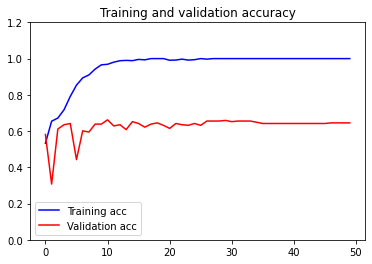

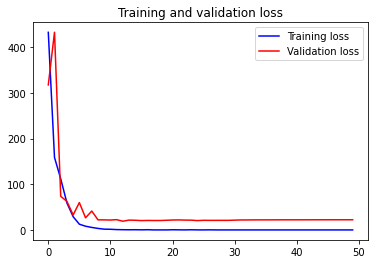

In [12]:
acc_1 = fit_generator1.history['acc']
val_acc_1 = fit_generator1.history['val_acc']
loss_1 = fit_generator1.history['loss']
val_loss_1 = fit_generator1.history['val_loss']

epochs_1 = range(len(acc_1))

plot_accuracy(x=epochs_1, 
              acc=acc_1, 
              val_acc=val_acc_1, 
              loss=loss_1, 
              val_loss=val_loss_1)


## Modelo 2

Incluimos capas de MaxPooling, Flatten y Dense.
Con la estructura sugerida en el trabajo práctico:
- Capa convolusional con 32 neuronas 
- Capa Pooling
- Capa Convolusional con 64 neuronas
- Capa Pooling
- Capa Convolusional con 128 neuronas
- Capa Pooling
- Capa Convolusional con 128 neuronas
- Capa Pooling
- Capa de Aplanamiento
- Capa Densa con 512 neuronas
- Capa de clasificación con la categorías.

In [13]:
from keras import layers
from keras import models

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3))) #tamaño de la imagen
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(3, activation='softmax'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)     

In [14]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
              metrics=['acc'])
fit_generator2 = model_2.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=EPOCHS,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 68s 821ms/step - loss: 12.2224 - acc: 0.5451 - val_loss: 1.1252 - val_acc: 0.5068
Epoch 2/50
82/82 [==============================] - 68s 821ms/step - loss: 0.7491 - acc: 0.7057 - val_loss: 1.3994 - val_acc: 0.4899
Epoch 3/50
82/82 [==============================] - 68s 823ms/step - loss: 0.4237 - acc: 0.8360 - val_loss: 1.5456 - val_acc: 0.5405
Epoch 4/50
82/82 [==============================] - 68s 819ms/step - loss: 0.2695 - acc: 0.9000 - val_loss: 1.5951 - val_acc: 0.6250
Epoch 5/50
82/82 [==============================] - 68s 819ms/step - loss: 0.1782 - acc: 0.9379 - val_loss: 1.9608 - val_acc: 0.5372
Epoch 6/50
82/82 [==============================] - 68s 819ms/step - loss: 0.1739 - acc: 0.9591 - val_loss: 1.8056 - val_acc: 0.5743
Epoch 7/50
82/82 [==============================] - 68s 822ms/step - loss: 0.1677 - acc: 0.9689 - val_loss: 3.5172 - val_acc: 0.5169
Epoch 8/50
82/82 [==============================] - 68s 823ms/step -

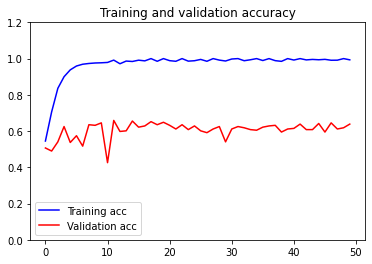

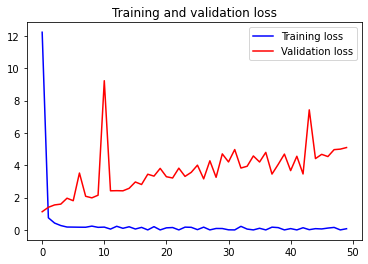

In [15]:
acc_2 = fit_generator2.history['acc']
val_acc_2 = fit_generator2.history['val_acc']
loss_2 = fit_generator2.history['loss']
val_loss_2 = fit_generator2.history['val_loss']

epochs_2 = range(len(acc_2))

plot_accuracy(x=epochs_2, 
              acc=acc_2, 
              val_acc=val_acc_2, 
              loss=loss_2, 
              val_loss=val_loss_2)

### Aumento de datos

Para el modelo anterior, se realiza aumento de cantidad de datos con el objetivo de tener más datos y prevenir también un eventual overfitting. 

Para el aumento de datos, se utiliza un generadores de entrenamiento con: reescalamiento, recorte, zoom y espejado horizontal.

* reescalado del inputs de 0,255 a 0,1
* rango de recorte (shear_range) para cortes aleatorios
* rango de zoom (zoom_range) para zoom aleatorio a las imágenes
* espejado horizontal (horizontal_flip) para obtener imágenes espejo horizontales)

Se utilizan las mismas funciones de activación y optimización, para así evaluar el mismo modelo.

Parámetros para aumento de datos

In [16]:
ROTATION_RANGE = 60
W_SHIFT = 0.2
H_SHIFT = 0.2
FILL_MODE = 'nearest'
RESCALE = 0.5
S_RANGE = 0.25
Z_RANGE = 0.25
H_FLIP = True

BATCH_SIZE_TRAIN = 50
BATCH_SIZE_TEST = 50

train_datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=W_SHIFT,
        height_shift_range=H_SHIFT,
        fill_mode=FILL_MODE,
        rescale=RESCALE,
        shear_range=S_RANGE,
        zoom_range=Z_RANGE,
        horizontal_flip=H_FLIP)

test_datagen = ImageDataGenerator(rescale=RESCALE)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=BATCH_SIZE_TEST,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


Vemos las imagenes generadas

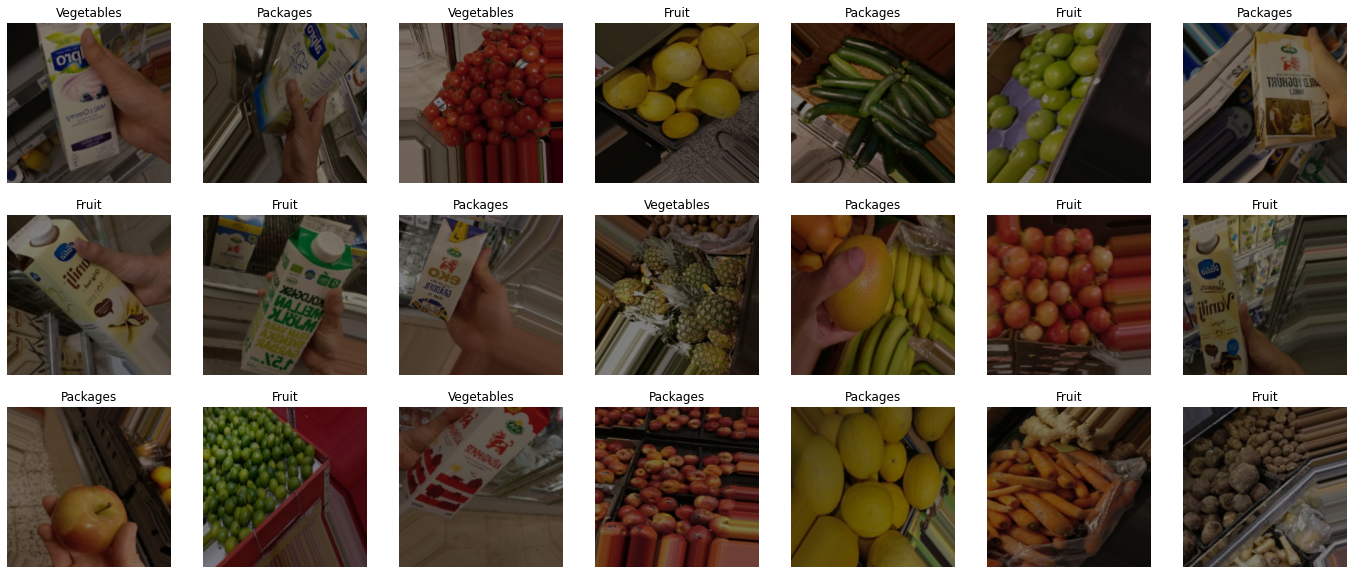

In [17]:
x = next(train_generator)

plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(x[0][i].astype("uint8"), aspect='auto')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# Lo vamos a necesitar para cuando calculemos las matrices de confusión.
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [19]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
              metrics=['acc'])

fit_generator2x = model_2.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 72s 870ms/step - loss: 0.8678 - acc: 0.6587 - val_loss: 0.9268 - val_acc: 0.6385
Epoch 2/50
82/82 [==============================] - 72s 869ms/step - loss: 0.6566 - acc: 0.7186 - val_loss: 0.9345 - val_acc: 0.6284
Epoch 3/50
82/82 [==============================] - 72s 864ms/step - loss: 0.6304 - acc: 0.7348 - val_loss: 0.8556 - val_acc: 0.6284
Epoch 4/50
82/82 [==============================] - 72s 872ms/step - loss: 0.6038 - acc: 0.7496 - val_loss: 0.8046 - val_acc: 0.6791
Epoch 5/50
82/82 [==============================] - 72s 869ms/step - loss: 0.5716 - acc: 0.7549 - val_loss: 0.9408 - val_acc: 0.6554
Epoch 6/50
82/82 [==============================] - 72s 874ms/step - loss: 0.5246 - acc: 0.7886 - val_loss: 0.8093 - val_acc: 0.6926
Epoch 7/50
82/82 [==============================] - 74s 896ms/step - loss: 0.5073 - acc: 0.7947 - val_loss: 0.7434 - val_acc: 0.7331
Epoch 8/50
82/82 [==============================] - 73s 877ms/step - 

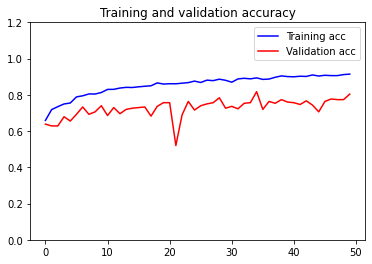

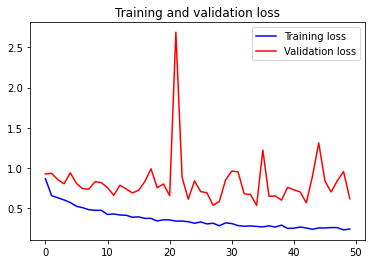

In [20]:
acc_2x = fit_generator2x.history['acc']
val_acc_2x = fit_generator2x.history['val_acc']
loss_2x = fit_generator2x.history['loss']
val_loss_2x = fit_generator2x.history['val_loss']

epochs_2x = range(len(acc_2x))

plot_accuracy(x=epochs_2x, 
              acc=acc_2x, 
              val_acc=val_acc_2x, 
              loss=loss_2x, 
              val_loss=val_loss_2x)

### Regularización: capa/s de dropout para regularizar.

In [21]:
from keras import layers
from keras import models

model_2R = models.Sequential()
model_2R.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3))) #tamaño de la imagen
model_2R.add(layers.MaxPooling2D((2, 2)))
model_2R.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2R.add(layers.MaxPooling2D((2, 2)))
model_2R.add(Dropout(0.25))
model_2R.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2R.add(layers.MaxPooling2D((2, 2)))
model_2R.add(Dropout(0.25))
model_2R.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model_2R.add(layers.MaxPooling2D((2, 2)))
model_2R.add(Dropout(0.25))
model_2R.add(layers.Flatten())
model_2R.add(layers.Dense(512, activation='relu'))
model_2R.add(layers.Dense(3, activation='softmax'))
model_2R.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)      

In [22]:
model_2R.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
              metrics=['acc'])

fit_generator2xR = model_2R.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 77s 921ms/step - loss: 6.9643 - acc: 0.5042 - val_loss: 0.9823 - val_acc: 0.5236
Epoch 2/50
82/82 [==============================] - 76s 917ms/step - loss: 0.8493 - acc: 0.6337 - val_loss: 0.8976 - val_acc: 0.6284
Epoch 3/50
82/82 [==============================] - 76s 920ms/step - loss: 0.7556 - acc: 0.6761 - val_loss: 0.8779 - val_acc: 0.6385
Epoch 4/50
82/82 [==============================] - 76s 921ms/step - loss: 0.6951 - acc: 0.7080 - val_loss: 0.8548 - val_acc: 0.6757
Epoch 5/50
82/82 [==============================] - 76s 923ms/step - loss: 0.6599 - acc: 0.7220 - val_loss: 0.8707 - val_acc: 0.6689
Epoch 6/50
82/82 [==============================] - 76s 918ms/step - loss: 0.6332 - acc: 0.7348 - val_loss: 0.7503 - val_acc: 0.6757
Epoch 7/50
82/82 [==============================] - 76s 917ms/step - loss: 0.6282 - acc: 0.7367 - val_loss: 0.7413 - val_acc: 0.7635
Epoch 8/50
82/82 [==============================] - 76s 917ms/step - 

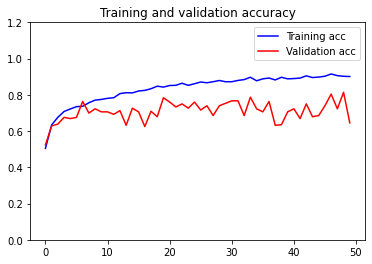

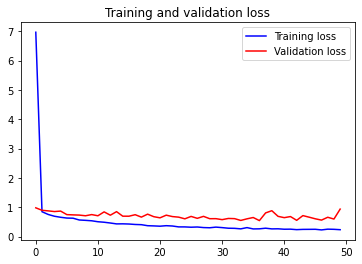

In [23]:
acc_2xR = fit_generator2xR.history['acc']
val_acc_2xR = fit_generator2xR.history['val_acc']
loss_2xR = fit_generator2xR.history['loss']
val_loss_2xR = fit_generator2xR.history['val_loss']

epochs_2xR = range(len(acc_2xR))

plot_accuracy(x=epochs_2xR, 
              acc=acc_2xR, 
              val_acc=val_acc_2xR, 
              loss=loss_2xR, 
              val_loss=val_loss_2xR)

# Redes Preentrenadas y Fine-Tuning!
Una estrategia para lidiar en redes neuronales profundas es usar redes previamente preentrenadas con bases de datos grandes y adaptarlas al problema de nuestro interés.

Para este propósito es necesario que la red preentrenada haya sido entrenada para resolver un problema de carácter mas general, del que nuestro problema se pueda consider un caso particular. 
Detalle de las redesde preentradas que se pueden usar en keras que fueron entrenadas en la base de datos de ImageNet
- Xception
- InceptionV3
- ResNet50
- VGG16
- VGG19
- MobileNet


## VGG16
Usaremos VGG16 por las siguientes razones:

- Tiene una arquitectura fácil de comprender y, en su caso, de implementar.
- Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.
- Contienen relativamente pocas capas convolucionales: 13 capas convolucionales y 3 densas, de ahí que en sus nombre incluya el 16.
- La red (modelo y pesos entrenados) esta diponible en Keras

La red VGG19 es una variante con mas capas de cálculo que la VGG16, por lo tanto mas pesada de almacenar en memoria y en requerimientos de cómputo.

VGG16 fue entrenada para resolver el problema de clasificación de 1000 clases en ImageNet y debe en sus pesos codificar información para extraer rasgos de muy distintas classes de representradas en las mas de 1.4 millones de fotografías de ImageNet. Entre esas clases hay muy distintas variedades, en muy distintos entornos lo que nos permite asumir que su etapa de extración de rasgos codifica, efectivamente, las relaciones epaciales que hacen a los objetos distinguibles. Por lo amplio de ImageNet, nos hace asumir que dichas relaciones espaciales son los suficientemente genéricas para poder codificar rasgos distintivos. 

Veamos como se comporta acá.

Se aplica VGG16 cambiando únicamente la capa de clasificación.

In [24]:
from keras.applications import vgg16

def create_vgg16():  
    model = vgg16.VGG16(include_top=False, weights=None, input_tensor=None, input_shape=(224,224,3), pooling=None, classes=CLASSES)
    return model

In [25]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

In [26]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

In [27]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = vgg(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [28]:
vgg.trainable = False #No entrenamos NADA del base_model. Vamos a agregar un clasificador y eso es lo q vamos a entrenar

In [29]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #esta funcion toma como entrada un tensor 4D con shape (batch_size, rows, cols, channels) y devuelve un tensor 2D con shape (batch_size, channels)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [31]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [33]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [34]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = vgg(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
model_vgg = tf.keras.Model(inputs, outputs)

In [35]:
model_vgg.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])

In [36]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [37]:
fit_generator_vgg = model_vgg.fit(train_generator,
                                  steps_per_epoch=steps_train,
                                  epochs=EPOCHS,
                                  validation_data=validation_generator,
                                  validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 252s 3s/step - loss: 2.4072 - acc: 0.4970 - val_loss: 1.6751 - val_acc: 0.5946
Epoch 2/50
82/82 [==============================] - 252s 3s/step - loss: 1.5265 - acc: 0.6379 - val_loss: 1.2362 - val_acc: 0.6993
Epoch 3/50
82/82 [==============================] - 253s 3s/step - loss: 1.2779 - acc: 0.6795 - val_loss: 1.1078 - val_acc: 0.7365
Epoch 4/50
82/82 [==============================] - 254s 3s/step - loss: 1.1121 - acc: 0.7330 - val_loss: 0.8899 - val_acc: 0.7905
Epoch 5/50
82/82 [==============================] - 253s 3s/step - loss: 0.9697 - acc: 0.7572 - val_loss: 0.7820 - val_acc: 0.7939
Epoch 6/50
82/82 [==============================] - 253s 3s/step - loss: 0.8385 - acc: 0.7708 - val_loss: 0.7329 - val_acc: 0.7939
Epoch 7/50
82/82 [==============================] - 252s 3s/step - loss: 0.8075 - acc: 0.7936 - val_loss: 0.7512 - val_acc: 0.8041
Epoch 8/50
82/82 [==============================] - 252s 3s/step - loss: 0.6920 - a

In [38]:
acc_vgg = fit_generator_vgg.history['acc']
val_vgg = fit_generator_vgg.history['val_acc']
loss_vgg = fit_generator_vgg.history['loss']
val_loss_vgg = fit_generator_vgg.history['val_loss']

epochs_vgg = range(len(acc_vgg))

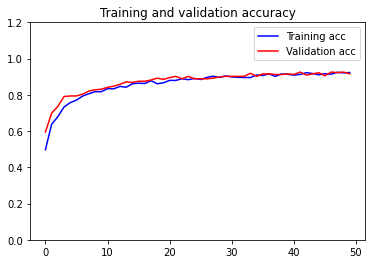

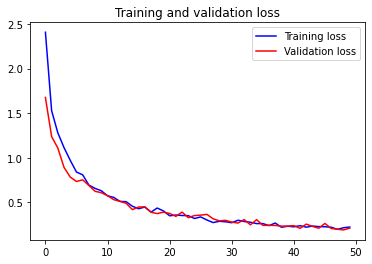

In [39]:
plot_accuracy(x=epochs_vgg,
              acc=acc_vgg,
              val_acc=val_vgg,
              loss=loss_vgg,
              val_loss=val_loss_vgg)

### FINE-TUNING (desde capa intermedia)

In [40]:
vgg.trainable = True

In [41]:
# Vemos cuantas capas hay en el modelo
print("Number of layers in the base model: ", len(vgg.layers))

# Aplicamos Fine-tune desde esta capa
fine_tune_at = 50

# Freezamos todas las capas antes de la capa especificada en `fine_tune_at`
for layer in vgg.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  19


In [42]:
model_vgg_tun = model_vgg
model_vgg_tun.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                      metrics=['acc'])

In [43]:
model_vgg_tun.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [44]:
fit_generator_vgg_tun = model_vgg_tun.fit(train_generator,
                                          steps_per_epoch=steps_train,
                                          epochs=EPOCHS,
                                          validation_data=validation_generator,
                                          validation_steps=steps_valid)

Epoch 1/50
82/82 [==============================] - 259s 3s/step - loss: 0.2063 - acc: 0.9212 - val_loss: 0.2047 - val_acc: 0.9223
Epoch 2/50
82/82 [==============================] - 259s 3s/step - loss: 0.2081 - acc: 0.9193 - val_loss: 0.2276 - val_acc: 0.9155
Epoch 3/50
82/82 [==============================] - 261s 3s/step - loss: 0.2125 - acc: 0.9140 - val_loss: 0.1922 - val_acc: 0.9257
Epoch 4/50
82/82 [==============================] - 260s 3s/step - loss: 0.1998 - acc: 0.9231 - val_loss: 0.2351 - val_acc: 0.9155
Epoch 5/50
82/82 [==============================] - 259s 3s/step - loss: 0.1961 - acc: 0.9258 - val_loss: 0.2058 - val_acc: 0.9189
Epoch 6/50
82/82 [==============================] - 259s 3s/step - loss: 0.1750 - acc: 0.9341 - val_loss: 0.2015 - val_acc: 0.9257
Epoch 7/50
82/82 [==============================] - 260s 3s/step - loss: 0.1785 - acc: 0.9269 - val_loss: 0.1899 - val_acc: 0.9257
Epoch 8/50
82/82 [==============================] - 259s 3s/step - loss: 0.2033 - a

In [45]:
acc_vgg_tun = fit_generator_vgg_tun.history['acc']
val_vgg_tun = fit_generator_vgg_tun.history['val_acc']
loss_vgg_tun = fit_generator_vgg_tun.history['loss']
val_loss_vgg_tun = fit_generator_vgg_tun.history['val_loss']

epochs_vgg_tun = range(len(acc_vgg_tun))

In [47]:
initial_epochs = 10

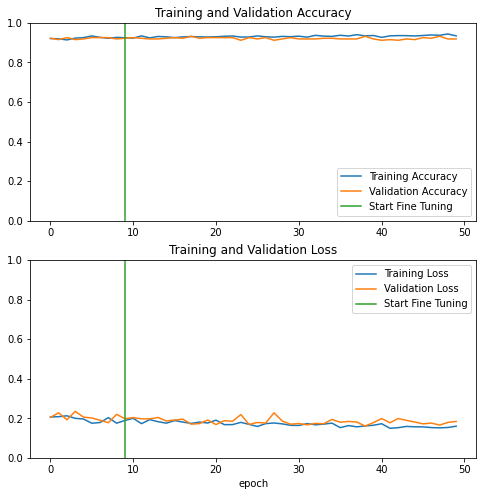

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_vgg_tun, label='Training Accuracy')
plt.plot(val_vgg_tun, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_vgg_tun, label='Training Loss')
plt.plot(val_loss_vgg_tun, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## ResNet
ResNet50 no es el primer modelo que proviene de la familia ResNet. El modelo original se llamó Residual net o ResNet (hito en el dominio de CV en 2015).

La principal motivación detrás de este modelo era evitar una precisión deficiente a medida que el modelo se hacía más profundo. 

El modelo ResNet tenía como objetivo abordar el problema de Vanishing Gradient. 

Arquitectura de la red<br>
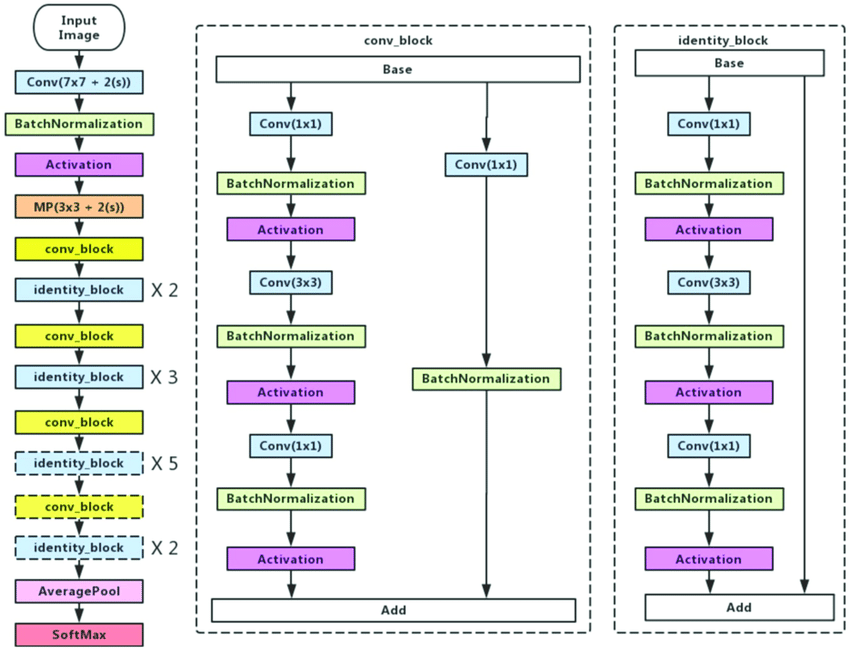


(Izquierda) Los bloques con línea de puntos representan módulos que podrían eliminarse en nuestros experimentos. <br>
(Medio) Bloque de convolución que cambia la dimensión de la entrada. <br>
(Derecha) Bloque de identidad que no cambiará la dimensión de la entrada.


Modelo base

In [49]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet", pooling=None, classes=CLASSES)

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
model_resnet.add(Dense(3, activation = 'softmax'))
# Say not to train first layer (ResNet) model as it is already trained
model_resnet.layers[0].trainable = False

Compilamos el modelo y probamos el optimizador SGD

In [51]:
model_resnet.compile(loss='categorical_crossentropy', 
                     optimizer='sgd',
                     metrics=['acc'])

In [52]:
fit_generator_resnet = model_resnet.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = steps_train, 
                                        epochs = EPOCHS)

Epoch 1/50
82/82 [==============================] - 170s 2s/step - loss: 36.2717 - acc: 0.6837 - val_loss: 11.9032 - val_acc: 0.7973
Epoch 2/50
82/82 [==============================] - 163s 2s/step - loss: 12.9625 - acc: 0.8091 - val_loss: 5.4140 - val_acc: 0.8784
Epoch 3/50
82/82 [==============================] - 163s 2s/step - loss: 9.2635 - acc: 0.8481 - val_loss: 8.6362 - val_acc: 0.8412
Epoch 4/50
82/82 [==============================] - 163s 2s/step - loss: 6.6242 - acc: 0.8773 - val_loss: 2.2611 - val_acc: 0.9155
Epoch 5/50
82/82 [==============================] - 163s 2s/step - loss: 5.7572 - acc: 0.8818 - val_loss: 1.7560 - val_acc: 0.9459
Epoch 6/50
82/82 [==============================] - 162s 2s/step - loss: 5.4079 - acc: 0.8985 - val_loss: 1.1859 - val_acc: 0.9527
Epoch 7/50
82/82 [==============================] - 163s 2s/step - loss: 4.1373 - acc: 0.9068 - val_loss: 2.0350 - val_acc: 0.9358
Epoch 8/50
82/82 [==============================] - 166s 2s/step - loss: 5.6497 

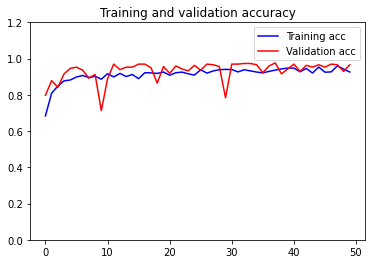

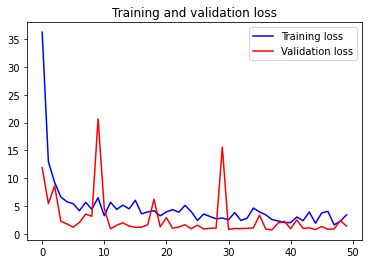

In [53]:
acc_resnet = fit_generator_resnet.history['acc']
val_resnet = fit_generator_resnet.history['val_acc']
loss_resnet = fit_generator_resnet.history['loss']
val_loss_resnet = fit_generator_resnet.history['val_loss']

epochs_resnet = range(len(acc_resnet))

plot_accuracy(x=epochs_resnet,
              acc=acc_resnet,
              val_acc=val_resnet,
              loss=loss_resnet,
              val_loss=val_loss_resnet)

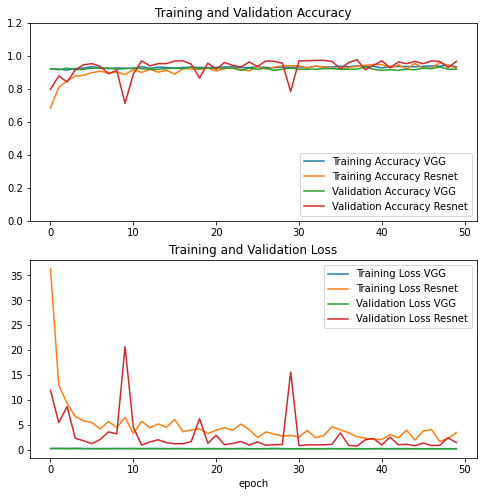

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_vgg_tun, acc_vgg_tun, label='Training Accuracy VGG')
plt.plot(epochs_resnet, acc_resnet, label='Training Accuracy Resnet')
plt.plot(epochs_vgg_tun, val_vgg_tun, label='Validation Accuracy VGG')
plt.plot(epochs_resnet, val_resnet, label='Validation Accuracy Resnet')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(bottom=0, top=1.2)

plt.subplot(2, 1, 2)
plt.plot(epochs_vgg_tun, loss_vgg_tun, label='Training Loss VGG')
plt.plot(epochs_resnet, loss_resnet, label='Training Loss Resnet')
plt.plot(epochs_vgg_tun, val_loss_vgg_tun, label='Validation Loss VGG')
plt.plot(epochs_resnet, val_loss_resnet, label='Validation Loss Resnet')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Reporte de clasificación
A continuación se calcula el reporte de clasificación para los modelos desarrollados a lo largo del trabajo práctico.

In [77]:
from sklearn.metrics import classification_report

models = [(model_1, 'Modelo 1: Base convolucional'), 
          (model_2, 'Modelo 2: Base convolucional + MaxPooling + Flatten + Dense + Data Augmentation'), 
          (model_vgg, 'VGG16'), 
          (model_vgg_tun, 'VGG16 + Fine tuning'), 
          (model_resnet, 'ResNet')]

X_test, y_test = next(validation_generator)
y_test=np.argmax(y_test, axis=1)


for model, name in models:
    print(f"--------- {name} ----------")
    
    y_pred = model.predict(X_test)
    y_pred=np.argmax(y_pred, axis=1)
 
    print("Classification Report:")
    print(classification_report(y_test,y_pred, target_names=class_names))
    print()

--------- Modelo 1: Base convolucional ----------
Classification Report:
              precision    recall  f1-score   support

       Fruit       0.58      0.73      0.65        15
    Packages       0.75      0.60      0.67        20
  Vegetables       0.60      0.60      0.60        15

    accuracy                           0.64        50
   macro avg       0.64      0.64      0.64        50
weighted avg       0.65      0.64      0.64        50


--------- Modelo 2: Base convolucional + MaxPooling + Flatten + Dense + Data Augmentation ----------
Classification Report:
              precision    recall  f1-score   support

       Fruit       0.71      0.80      0.75        15
    Packages       0.86      0.95      0.90        20
  Vegetables       0.82      0.60      0.69        15

    accuracy                           0.80        50
   macro avg       0.80      0.78      0.78        50
weighted avg       0.80      0.80      0.79        50


--------- VGG16 ----------
Classificati

El modelo ResNet es el que mejor f1-score (media armónica entre presición y recall) presenta.